# Итоговый проект на курсе Data Science школа SkillFactory
# «Модель прогнозирования стоимости жилья для агентства недвижимости»

**Цель:** разработать модель, которая позволила бы агентству недвижимости обойти конкурентов по скорости и качеству совершения сделок.

In [39]:
# Импорт библиотек
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import os

import seaborn as sns
import plotly.subplots as spimport
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder, CatBoostEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
%matplotlib inline

In [14]:
# Фиксация RANDOM_SEED
RANDOM_SEED = 42

In [15]:
# Фиксация версии пакетов
!pip freeze > requirements.txt

## Моделирование и оценка модели

In [16]:
df = pd.read_csv('data/eda_data.csv')
df.head()

,baths,sqft,target,private_pool,avg_schools_rating,school_distance_min,status_Active,status_Auction,status_Back on market,status_Closed,...,propertyType_mobile home,propertyType_multi family,propertyType_other,propertyType_ranch,propertyType_single family,propertyType_townhouse,state_label,year_label,city_label,zipcode_label
0,1.252763,7.972466,12.943237,False,1.648659,0.993252,True,False,False,False,...,False,False,False,False,True,False,19,206,1374,812
1,1.098613,7.574045,12.644328,False,1.386295,0.009951,False,False,False,False,...,False,False,False,False,True,False,33,206,1383,3946
2,-13.815511,7.317876,12.109011,False,0.847298,-0.223142,True,False,False,False,...,False,False,True,False,False,False,5,193,1073,1362
3,1.098613,7.565275,12.650742,False,1.098613,-0.510824,False,False,False,False,...,False,False,False,False,True,False,29,206,658,2473
4,0.693148,7.170120,13.413539,False,1.897120,-1.203969,False,False,False,False,...,False,False,False,False,False,False,22,152,486,255


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280292 entries, 0 to 280291
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   baths                       280292 non-null  float64
 1   sqft                        280292 non-null  float64
 2   target                      280292 non-null  float64
 3   private_pool                280292 non-null  bool   
 4   avg_schools_rating          280292 non-null  float64
 5   school_distance_min         280292 non-null  float64
 6   status_Active               280292 non-null  bool   
 7   status_Auction              280292 non-null  bool   
 8   status_Back on market       280292 non-null  bool   
 9   status_Closed               280292 non-null  bool   
 10  status_Coming soon          280292 non-null  bool   
 11  status_Contingent           280292 non-null  bool   
 12  status_For rent             280292 non-null  bool   
 13  status_For sal

### Разделение данных

In [18]:
y = df['target']
X = df.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

## 1. "Наивная" модель 
Эта модель будет предсказывать среднюю стоимость по общей площади и городу. 
C ней будем сравнивать другие модели.

In [19]:
# Наивная модель
class NaiveModel:
    def __init__(self):
        self.means = None

    def fit(self, X, y):
        X_df = pd.DataFrame(X, columns=['city_label'])
        y_df = pd.DataFrame(y, columns=['target'])
        df = pd.concat([X_df, y_df], axis=1)
        self.means = df.groupby(['city_label'])['target'].mean().reset_index()

    def predict(self, X):
        X = pd.DataFrame(X, columns=['city_label']).copy()
        X['mean'] = np.nan
        for idx, row in self.means.iterrows():
            X.loc[(X['city_label'] == row['city_label']), 'mean'] = row['target']
        
        X['mean'].fillna(X['mean'].mean(), inplace=True)
        return X['mean'].to_numpy()

naive_model = NaiveModel()

# Обучение модели
naive_model.fit(X_train, y_train)

# Предсказание с помощью модели
y_pred_train = naive_model.predict(X_train)
y_pred_test = naive_model.predict(X_test)

# Расчет метрик
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.44
Test MSE: 0.44
Train MAE: 0.48
Test MAE: 0.48
Train R2: 0.40
Test R2: 0.41


MAE (Средняя абсолютная ошибка, Mean Absolute Error) - это мера ошибки, вычисленная как среднее значение абсолютных значений ошибок. Меньшие значения MAE указывают на лучшую точность модели. В данном случае:

Train MAE: 0.48 - это средняя абсолютная ошибка на обучающей выборке.
Test MAE: 0.48 - это средняя абсолютная ошибка на тестовой выборке.
R^2 (коэффициент детерминации) - статистическая мера, которая показывает, насколько хорошо вариации зависимой переменной объясняются моделью. Значения R^2 находятся в диапазоне от -∞ до 1. Чем ближе значение R^2 к 1, тем лучше модель объясняет зависимость между переменными. В данном случае:

Train R2: 0.40 - это коэффициент детерминации на обучающей выборке.
Test R2: 0.41 - это коэффициент детерминации на тестовой выборке.

### Выводы
Значения MSE и MAE, как для обучающей, так и для тестовой выборки, одинаковы. Это говорит о том, что модель демонстрирует схожую производительность на обеих выборках и не страдает от переобучения или недообучения.

Значения R2 меньше 0.5, что говорит о том, что модель слабо объясняет зависимость между переменными. Это может свидетельствовать о низкой предсказательной способности "наивной" модели.

## 2. Линейная регрессия LinearRegression

In [20]:
# Модель линейной регрессии
model = LinearRegression(fit_intercept=False)

# Обучение модели
model.fit(X_train, y_train)

# Предсказания с помощью модели
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Расчет метрик с помощью модели
mse_train = metrics.mean_squared_error(y_train, y_train_pred)
mse_test = metrics.mean_squared_error(y_test, y_test_pred)
mae_train = metrics.mean_absolute_error(y_train, y_train_pred)
mae_test = metrics.mean_absolute_error(y_test, y_test_pred)
r2_train = metrics.r2_score(y_train, y_train_pred)
r2_test = metrics.r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.45
Test MSE: 0.45
Train MAE: 0.48
Test MAE: 0.48
Train R2: 0.38
Test R2: 0.39


### Выводы

Значения на тренировочных и тестовых выборках не сильно отличаются, значит модель не переобучена.

Но значения ошибок такое же(MAE = 0.48) или даже немного больше(MSE = 0.45), чем в "наивной" модели.

В то же время коэффициент детерминации (далее R2) чем выше, тем лучше, стоящие показатели модели должны быть больше 0,5. На модели линейной регрессии у нас R2 равно 0.39 на тестовой выборке, и 0.38 на тренировочной. Это значит модель смогла уловить 39 % и 38 % информации о дисперсии соответственно.

Метрики хуже, чем у "наивной" модели.

Из всего этого можно сделать вывод, что есть куда развивать модель, пробовать подбор параметров, ансамблевые модели.

## 3. Регуляризация Ridge (L2)

Так как ,судя по метрикам, у нас нет переобучения, мы можем использовать регуляризацию для улучшения обобщающей способности модели. Данных у нас достаточно, и мы избавились от выбросов. Попробуем улучшить модель Ridge регуляризацией.

In [21]:
# Модель Ridge регрессии
ridge = Ridge(alpha = 10)

# Обучение модели 
ridge.fit(X_train, y_train)
 
# Предсказание с помощью модели
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

# Расчет метрик
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.45
Test MSE: 0.45
Train MAE: 0.48
Test MAE: 0.48
Train R2: 0.38
Test R2: 0.39


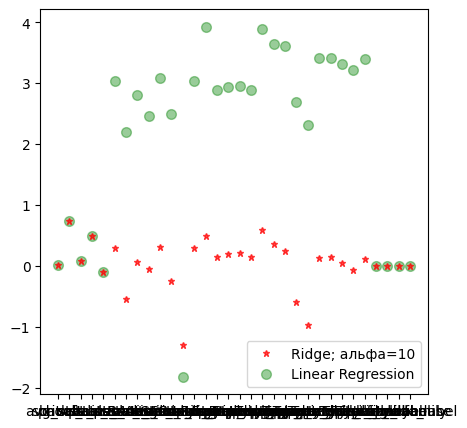

In [22]:
# Графики весов двух моделей LinearRegression и Ridge
features = X.columns
 
plt.figure(figsize = (5, 5))
plt.plot(features, ridge.coef_, alpha=0.7, linestyle='none' , marker='*', markersize=5, color='red', label=r'Ridge; альфа=10', zorder = 7)
plt.plot(features, model.coef_, alpha=0.4, linestyle='none', marker='o', markersize=7, color='green',label='Linear Regression')
plt.xticks(rotation = 0)
plt.legend()
plt.show()

### Выводы

Метрики не изменились, что указывает на то, что регуляризация нам не помогла в улучшении предсказаний. Хотя веса более сбалансированы. Попробуем другой способ регуляризации ElasticNetCV. Elastic Net использует как L1, так и L2 регуляризацию и координатный спуск для минимизации функции потерь.

## 4. ElacticNetCV

In [23]:
# Модель ElasticNetCV с кросс-валидацией по 5 фолдам
elastic = ElasticNetCV(cv=5, random_state=RANDOM_SEED)

# Обучение модели
elastic.fit(X_train, y_train)

# Предсказания для обучающей и тестовой выборок
y_train_pred = elastic.predict(X_train)
y_test_pred = elastic.predict(X_test)

# Расчет метрик
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.58
Test MSE: 0.59
Train MAE: 0.54
Test MAE: 0.55
Train R2: 0.20
Test R2: 0.21


### Выводы
MSE (Mean Squared Error) - В данном случае обучающая выборка имеет значение 0.58, а тестовая - 0.59. Эти числа близки, что означает, что модель не переобучилась, но в то же время обобщающая способность модели может быть не очень хорошей из-за высоких значений ошибок.

MAE (Mean Absolute Error) - В данном случае средняя абсолютная ошибка составляет 0.54 на обучающей, и 0.55 на тестовой выборке.

R2 (коэффициент детерминации) -  В данном случае R2 равен 0.20 для обучающей выборки и 0.21 для тестовой выборки. Эти значения невысоки, что говорит о плохом качестве модели и низкой способности объяснить изменчивость данных.

Модель не является оптимальной.

Метрики ухудшились, хотя переобучения при сравнении трейна и тестовой выборки нет. Обучим сложную ансамблевую модель бэггинга.

## 5. RandomForestRegressor

In [24]:
# Модель RandomForestRegressor
rf_regressor = RandomForestRegressor(random_state=RANDOM_SEED)

# Обучение модели
rf_regressor.fit(X_train, y_train)

# Предсказания на обучающей и тестовой выборок
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)

# Расчет метрик
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.01
Test MSE: 0.09
Train MAE: 0.07
Test MAE: 0.19
Train R2: 0.98
Test R2: 0.87


### Выводы
Среднеквадратическая ошибка (MSE) - В данном случае, значение MSE для обучающей выборки составляет 0.01, тогда как для тестовой выборки - 0.09. Такое различие может указывать на небольшое переобучение модели.

Средняя абсолютная ошибка (MAE) -  В данном случае, значения MAE составили 0.07 для обучающей выборки и 0.19 для тестовой выборки. Разница между этими значениями также может указывать на переобучение.

Коэффициент детерминации (R2) -  В данном случае, R2 равен 0.98 для обучающей выборки и 0.87 для тестовой выборки. Эти значения указывают на то, что модель довольно хорошо работает на обучающей выборке и неплохо предсказывает на тестовой выборке, хотя значение R2 на тестовой выборке заметно ниже, что также может указывать на переобучение модели.

В целом, результаты показывают, что модель имеет хорошую производительность на обучающей выборке, но на тестовой выборке результаты хуже, что может свидетельствовать о переобучении.

На данный момент это лучшая модель.
Попробую поддобрать гиперпараметры для модели, для ее оптимизации. Будем делать это с помощью RandomizedSearchCV.

## 6. RandomizedSearchCV

In [25]:
# Задаем сетку параметров
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
# Определяем гиперпараметры           
random_search_forest = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
y_test_pred = random_search_forest.predict(X_test)

CPU times: total: 5min 6s
Wall time: 45min 19s


In [26]:
# Расчет метрик
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}")
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.05
Test MSE: 0.10
Train MAE: 0.14
Test MAE: 0.20
Train R2: 0.92
Test R2: 0.86


### Выводы
Подбор оптимальных гиперпараметров привел к небольшому увеличению ошибок MSE и MAE, в сравнении RandomForestRegressor, а значение R2 немного снизилось. При этом разница в метриках между трейном и тестовыми выборками меньше, а значит модель более устойчива, менее переобучена. На данный момент это наиболее удачная и сбалансированная модель.
Попробуем еще одну модель CatBoostRegressor.

## 7. CatBoostRegressor

CatBoostRegressor работает с необработанными категориальными данными. Поэтому буду использовать датафрейм без кодирования категориальных признаков.

In [27]:
# Чтение данных без кодирования категориальных признаков
df = pd.read_csv('data/cleaned_data_for_CatBoost.csv')
df.head()

,status,propertyType,baths,city,sqft,zipcode,state,target,private_pool,avg_schools_rating,school_distance_min,Year built
0,Active,single family,1.252763,Southern Pines,7.972466,28387,NC,12.943237,False,1.648659,0.993252,2019
1,For sale,single family,1.098613,Spokane Valley,7.574045,99216,WA,12.644328,False,1.386295,0.009951,2019
2,Active,other,-13.815511,POINCIANA,7.317876,34759,FL,12.109011,False,0.847298,-0.223142,2006
3,unknown,single family,1.098613,Houston,7.565275,77080,TX,12.650742,False,1.098613,-0.510824,2019
4,For sale,condo,0.693148,Flushing,7.170120,11354,NY,13.413539,False,1.897120,-1.203969,1965


In [40]:
# Разделение данных
y = df['target']
X = df.drop(['target'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

In [42]:
# Список категориальных признаков
cat_features = ['status', 'propertyType', 'zipcode', 'state', 'city', 'Year built']
param_grid = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}
cb_model = CatBoostRegressor(random_seed=RANDOM_SEED, silent=True)
grid_search = GridSearchCV(estimator=cb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train, cat_features=cat_features)
best_params = grid_search.best_params_
best_cb_model = CatBoostRegressor(iterations=best_params['iterations'], learning_rate=best_params['learning_rate'], depth=best_params['depth'], l2_leaf_reg=best_params['l2_leaf_reg'], random_seed=RANDOM_SEED, silent=True)
best_cb_model.fit(X_train, y_train, cat_features=cat_features)

y_train_pred = best_cb_model.predict(X_train)
y_test_pred = best_cb_model.predict(X_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [43]:
# Расчет метрик
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred) 
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train MSE: {mse_train:.2f}")
print(f"Test MSE: {mse_test:.2f}")
print(f"Train MAE: {mae_train:.2f}")
print(f"Test MAE: {mae_test:.2f}") 
print(f"Train R2: {r2_train:.2f}")
print(f"Test R2: {r2_test:.2f}")

Train MSE: 0.09
Test MSE: 0.10
Train MAE: 0.20
Test MAE: 0.21
Train R2: 0.88
Test R2: 0.87


### Выводы
Алгоритм градиентного бустинга для задачи регрессии CatBoostRegressor работает так же хорошо, как RandomizedSearchCV.

На трейновой выборке ошибки MAE, MSE и коэффициен детерминации показывают чуть похуже результат, чем модель RandomizedSearchCV.

На тестовой выборке результаты аналогичны RandomizedSearchCV, только MAE На одну сотку больше (0,21).

Вцелом модель CatBoostRegressor чуть лучше справляется с переобучением, а по значению ошибок практически совпадает с RandomizedSearchCV, но обучение занимает значительно больше времени (в моем случае 280 минут).



## Итоги по построению и оценке моделей

In [31]:
# построим таблицу с обобщенными данными
metrics = {'Metric': ['Train MSE', 'Test MSE', 'Train MAE', 'Test MAE', 'Train R2', 'Test R2'],
           'NaiveModel':[0.44, 0.44, 0.48, 0.48, 0.40, 0.41],
           'LinearRegression': [0.45, 0.45, 0.48, 0.48, 0.38, 0.39],
           'Ridge':[0.45, 0.45, 0.48, 0.48, 0.38, 0.39],
           'ElasticNetCV': [0.58, 0.59, 0.54, 0.55, 0.20, 0.21],
           'RandomForestRegressor': [0.01, 0.09, 0.07, 0.19, 0.98, 0.87],
           'RandomizedSearchCV': [0.05, 0.10, 0.14, 0.20, 0.92, 0.86],
           'CatBoostRegressor':[0.09, 0.10, 0.20, 0.21, 0.88, 0.87]
}

metric_com = pd.DataFrame(metrics)
metric_com

,Metric,LinearRegression,Ridge,ElasticNetCV,RandomForestRegressor,RandomizedSearchCV,CatBoostRegressor
0,Train MSE,0.46,0.46,0.59,0.01,0.05,0.08
1,Test MSE,0.45,0.45,0.58,0.09,0.10,0.10
2,Train MAE,0.49,0.49,0.55,0.07,0.14,0.20
3,Test MAE,0.48,0.48,0.54,0.18,0.20,0.21
4,Train R2,0.37,0.37,0.19,0.98,0.93,0.89
5,Test R2,0.37,0.37,0.19,0.87,0.86,0.86


*Итоговый вывод:*

Анализируя общую таблицу, можно сказать, что наилучшие модели RandomizedSearchCV и CatBoostRegressor. Показатели ошибок MSE и MAE наименьшие у этих моделей, коэффициент детерминации R2 наибольший для трейновой и тестовой выборок. При этом разница между выборками у этих моделей минимальная, что указывает на отсутствие переобучения у моделей.

Но затраты времени на обучение значительно меньше у модели RandomizedSearchCV.